In [259]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import math
import torch
import torchvision
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import lbg_forecast.cosmology as cos

# Function x**(1/2)
def forward(x):
    return abs(x)**(1/1.5)

def inverse(x):
    return x**(1.5)

def get_training_data(plot=False):

    data = ascii.read("csfr_data/obs.txt")
    csfr_rows = data['Type']=="csfr"
    csfr_uv_rows = data['Type']=="csfr_(uv)"
    rows = np.logical_or(csfr_rows, csfr_uv_rows)

    z1 = np.array(data["Z1"])[rows]
    z2 = np.array(data["Z2"])[rows]
    redshift = (z2+z1)/2

    z_err_l = redshift-z1
    z_err_h = z2-redshift

    log_val = np.array(data["Val"])[rows]
    log_err_h = np.array(data["Err_h"])[rows]
    log_err_l = np.array(data["Err_l"])[rows]

    log_val_err_h = log_val + log_err_h
    log_val_err_l = log_val - log_err_l

    val = 10**log_val
    val_err_h = 10**log_val_err_h
    val_err_l = 10**log_val_err_l

    err_h = val_err_h - val
    err_l = val - val_err_l

    train_redshift = redshift
    train_csfrd = val
    train_csfrd_errors = err_h+err_l

    #if(plot):
    plt.errorbar(redshift, val, yerr=[err_l, err_h], fmt='ko', capsize=2)
    plt.yscale("log")
    plt.xscale('function', functions=(forward, inverse))
    plt.xlabel("redshift")
    plt.ylabel("csfrd")
    plt.xticks(np.arange(0, 10, 1.0))
    plt.xlim(0, 10)
    plt.ylim(0.001, 0.2)

    return train_redshift, train_csfrd, train_csfrd_errors, err_l, err_h

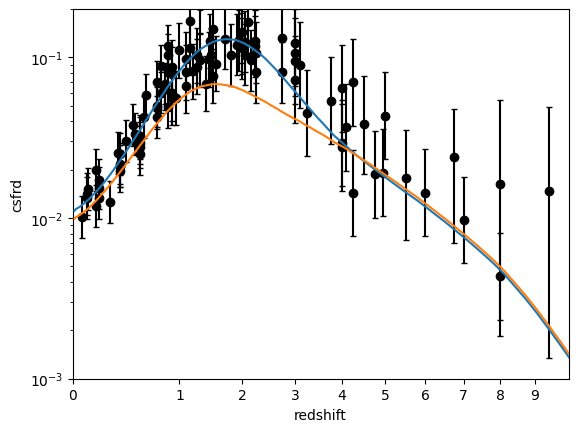

In [260]:
data = ascii.read("csfr_data/csfrs.dat")  

scale = np.array(data["Scale"])
redshift = cos.scale_to_z(scale)
total_obs_csfr = np.array(data["Total_Obs_CSFR"])
total_obs_csfr_err_p = np.array(data["Err+"])
total_obs_csfr_err_n = np.array(data["Err-"])

total_obs_csfr_uv = np.array(data["Total_Obs_CSFR_UV"])
total_obs_csfr_uv_err_p = np.array(data["Err+_1"])
total_obs_csfr_uv_err_n = np.array(data["Err-_1"])

true_csfr = np.array(data["True_CSFR"])
true_csfr_err_p = np.array(data["Err+_2"])
true_csfr_err_n = np.array(data["Err-_2"])

plt.errorbar(redshift, total_obs_csfr, zorder=1000)#, yerr=[total_obs_csfr_err_n, total_obs_csfr_err_p])
#plt.errorbar(redshift, total_obs_csfr_uv, zorder=1000)#, yerr=[total_obs_csfr_uv_err_n, total_obs_csfr_uv_err_p])
plt.errorbar(redshift, true_csfr, zorder=1000)#, yerr=[true_csfr_err_n, true_csfr_err_p])

training_data = get_training_data(True)
train_redshift = torch.from_numpy(training_data[0])
train_csfrd = torch.from_numpy(training_data[1])
train_csfrd_errors = torch.from_numpy(training_data[2])
train_csfrd_errors_l = torch.from_numpy(training_data[3])
train_csfrd_errors_h = torch.from_numpy(training_data[4])

In [284]:
train_scaled_csfrd = (train_csfrd - train_csfrd.mean())/train_csfrd.std()
#plt.scatter(train_redshift, train_scaled_csfrd)
#train_scaled_csfrd.std()

In [285]:
#data pre-processing
train_scaled_csfrd = (train_csfrd - train_csfrd.mean())/train_csfrd.std()

#construct gp
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_redshift, train_scaled_csfrd, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [286]:
training_iter = 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, train_scaled_csfrd)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

1.0325938359981275
1.0301385351060754
1.0276936832197985
1.0252596673100831
1.0228366422241115
1.020424559370978
1.0180230112890114
1.0156312063857964
1.013248123478358
1.010872673581008
1.0085041394523402
1.0061421781887023
1.0037868700631394
1.0014383946939804
0.9990971659635993
0.996763574399534
0.9944380633840741
0.9921210832519078
0.989813034193777
0.9875142987023275
0.9852252700484938
0.9829462953147817
0.9806777343730261
0.9784199001063124
0.9761730883665914
0.9739376163676503
0.9717137572990366
0.9695018038631527
0.9673019871248476
0.965114614175967
0.9629399026372631
0.9607781192848127
0.9586294527073993
0.9564942242138047
0.9543726138247566
0.9522649130633264
0.9501713028937938
0.9480920223682825
0.9460273369628349
0.9439774557680077
0.9419426161430785
0.9399230270916443
0.9379189271588851
0.9359305204517189
0.933958015730294
0.9320016842556792
0.93006168810006
0.9281382411563942
0.9262315525029684
0.9243418016666499
0.9224691972010302
0.9206138986402305
0.918776121707162
0.9

In [306]:
train_csfrd.std()

tensor(0.0442, dtype=torch.float64)

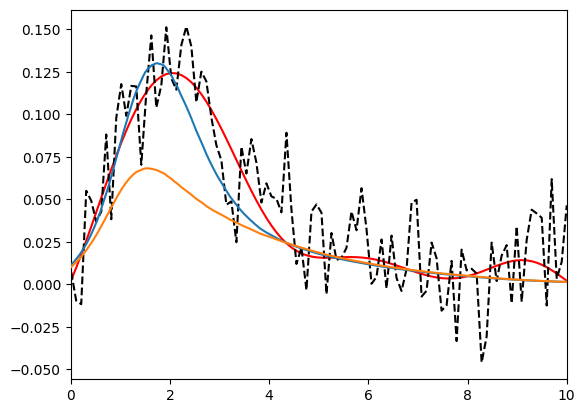

In [373]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0.01, 10, 100)#torch.sort(train_redshift)[0]#torch.sort(train_redshift)[0]

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

with torch.no_grad():
    plt.plot(test_x, f_preds.sample().numpy()*train_csfrd.std().item() + train_csfrd.mean().item(), c='r')
    plt.plot(test_x, y_preds.sample().numpy()*train_csfrd.std().item() + train_csfrd.mean().item(), c='k', ls='--')
    plt.errorbar(redshift, total_obs_csfr, zorder=1000)
    plt.errorbar(redshift, true_csfr, zorder=1000)
    plt.xlim(0, 10)

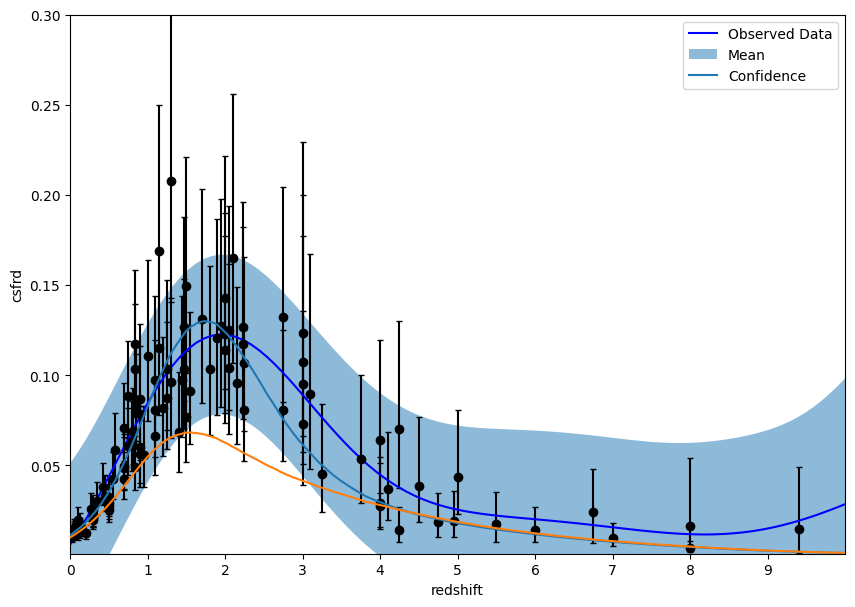

In [375]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))


    ax.errorbar(redshift, total_obs_csfr, zorder=1000)
    ax.errorbar(redshift, true_csfr, zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_redshift.numpy(), train_csfrd.numpy(), yerr=[train_csfrd_errors_l, train_csfrd_errors_h], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), y_preds.mean.numpy()*train_csfrd.std().item() + train_csfrd.mean().item(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy()*train_csfrd.std().item() + train_csfrd.mean().item(), upper.numpy()*train_csfrd.std().item() + train_csfrd.mean().item(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    #ax.set_yscale("log")
    #ax.set_xscale('function', functions=(forward, inverse))
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_xticks(np.arange(0, 10, 1.0))
    ax.set_xlim(0, 10)
    ax.set_ylim(0.001, 0.3)